In [1]:
from ipywidgets import interact
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import torch

In [3]:
from functools import partial

# Plotting function

In [4]:
def plot_func(f, title=None, min_x=-3, max_x=3, ylim=None, color='red'):
    x = torch.linspace(min_x, max_x, 100)
    plt.plot(x, f(x), color=color)
    if ylim: plt.ylim(*ylim)
    if title: plt.title(title)

In [5]:
def f(x):
    return 0.5*x**3 - 3*x**2 + 2*x + 1

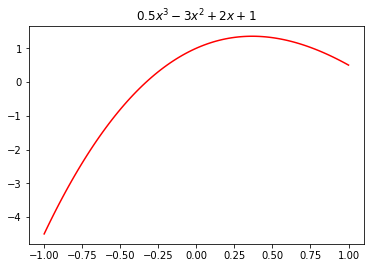

In [6]:
plot_func(f, "$0.5x^3 - 3x^2 + 2x+ 1$", -1, 1)

# Model architecutre

In [7]:
# true function that we want to reconstruct, takes params and input:x
def polynom3(a3, a2, a1, a0, x):
    return a3*x**3 + a2*x**2 + a1*x + a0

In [8]:
# helper function to generate "model instance" with fixed weights so we can apply it to the input:x
# return function that takes single input:x
def make_pol3(a3, a2, a1, a0):
    return partial(polynom3, a3, a2, a1, a0) 

# Select shape of function that I like 

In [9]:
def format_polynom_part(coefficient, power, is_first_nonzero_term):
    if coefficient == 0:
        return ""
    sign = "-" if coefficient < 0 else "+" if not is_first_nonzero_term else ""
    coeff_str = "" if abs(coefficient) == 1 and power != 0 else f"{abs(coefficient):.2f}".rstrip('0').rstrip('.')
    space = " " if not is_first_nonzero_term or sign == "+" else ""
    term = f"{sign}{space}{coeff_str}{'x' if power else ''}{'^' + str(power) if power > 1 else ''}".strip()
    return term

def format_cubic_polynomial(a3, a2, a1, a0):
    coefficients = [a3, a2, a1, a0]
    terms = []
    first_nonzero_found = False

    for i, coeff in enumerate(coefficients):
        power = len(coefficients) - i - 1
        if coeff != 0 and not first_nonzero_found:
            first_nonzero_found = True
            terms.append(format_polynom_part(coeff, power, True))
        else:
            terms.append(format_polynom_part(coeff, power, False))

    res = " ".join(filter(None, terms))
    return f"${res}$"

# Example usage
print(format_cubic_polynomial(1, 2, -1, 10))  # Output: "x^3 + 2x^2 - x + 10"
print(format_cubic_polynomial(-3, 0, 5, -1))  # Output: "-3x^3 + 5x - 1"
print(format_cubic_polynomial(1, 2, -1, 10))  # Output: x^3 + 2.00x^2 - x + 10.00
print(format_cubic_polynomial(0, -2.4345, 5, -1))  # Output: -2.43x^2 + 5.00x - 1.00

$x^3 + 2x^2 - x + 10$
$-3x^3 + 5x - 1$
$x^3 + 2x^2 - x + 10$
$-2.43x^2 + 5x - 1$


In [10]:
@interact(
    a3=(-3,3,0.05),
    a2=(-3,3,0.05),
    a1=(-3,3,0.05),
    a0=(-3,3,0.05),
)
def choose_params(a3=.25, a2=-.15, a1=-1.45, a0=1.5):
    f = make_pol3(a3, a2, a1, a0)
    plot_func(f, format_cubic_polynomial(a3, a2, a1, a0))

interactive(children=(FloatSlider(value=0.25, description='a3', max=3.0, min=-3.0, step=0.05), FloatSlider(val…

In [223]:
# model params that we want to reconstruct
hiddent_actual_params = [0.25, -0.15, -1.45, 1.5]
#hiddent_actual_params = [0.0, 3, 2, 1]

In [224]:
hidden_function = make_pol3(*hiddent_actual_params)
hidden_func_title = format_cubic_polynomial(*hiddent_actual_params)

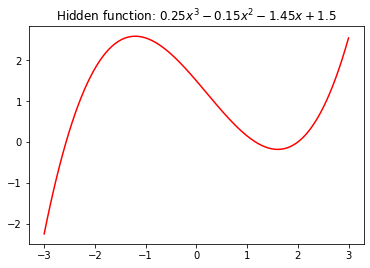

In [225]:
plot_func(hidden_function, f"Hidden function: {hidden_func_title}")

# Generate "training" data
* use known function to generate data with addiitonal noise

In [226]:
def noise(scale, x):
    return np.random.normal(scale=scale, size=len(x))
def add_noise(x, mul, add):
    return x * (1 + noise(mul, x)) + noise(add, x)

In [227]:
add_noise(torch.linspace(0,10,11), 0.1, 0.3)

tensor([-0.1855,  0.8870,  1.9857,  2.8724,  3.8132,  5.8968,  4.8791,  6.4129,
         8.6596,  8.8557, 12.1018], dtype=torch.float64)

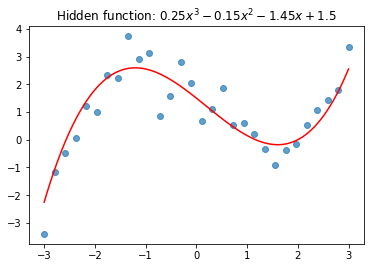

In [228]:
n_examples = 30
train_x_min = -3
train_x_max = 3

np.random.seed(1)

train_x = torch.linspace(train_x_min, train_x_max, n_examples)
train_y = add_noise(hidden_function(train_x), mul=0.2, add=.6)


plot_func(hidden_function, f"Hidden function: {hidden_func_title}")
plt.scatter(train_x, train_y, alpha=0.7)

# Manual interactive fitting
* plot train data points
* use interactive plot of the function with manually selected parameters
* output loss

In [229]:
def mae_loss(y_true, y_pred):
    return (y_true-y_pred).abs().mean()

In [230]:
print("Loss of actual function on train data:", mae_loss(train_y, hidden_function(train_x)))

Loss of actual function on train data: tensor(0.5020, dtype=torch.float64)


In [231]:
@interact(
    a3=(-3,3,0.01),
    a2=(-3,3,0.01),
    a1=(-3,3,0.01),
    a0=(-3,3,0.01),
)
def manual_params_fitting(a3=0.1, a2=-.1, a1=.1, a0=.1):
    f = make_pol3(a3, a2, a1, a0)
    loss = mae_loss(train_y, f(train_x))
    plot_func(f, f"Loss: {loss:.3f}")
    plt.scatter(train_x, train_y, alpha=0.7)

interactive(children=(FloatSlider(value=0.1, description='a3', max=3.0, min=-3.0, step=0.01), FloatSlider(valu…

# Gradient descent
* save the series of params + loss so we can plot trace

## One iteration of grad descent

In [232]:
# set parmas randomly
# !tell pytorch that we want to calc grads via requires_grad parameter
np.random.seed(42)
m_params = torch.tensor(np.random.normal(size=4), requires_grad=True)
m_params

tensor([ 0.4967, -0.1383,  0.6477,  1.5230], dtype=torch.float64,
       requires_grad=True)

In [233]:
display(m_params.grad)

None

In [234]:
model = make_pol3(*m_params)
y_pred = model(train_x)
loss = mae_loss(train_y, y_pred)
# calc grad
m_params.grad = None # reset before grad calculation, do we need to do this?
loss.backward()
# params should have gradient
print("current loss: ", loss)
print("gradient ", m_params.grad)

current loss:  tensor(4.9569, dtype=torch.float64, grad_fn=<MeanBackward0>)
gradient  tensor([ 7.4560e+00, -1.1921e-07,  1.5517e+00,  7.4506e-09],
       dtype=torch.float64)


In [235]:
# update params
# we need to turn off gradient update rules for this
learning_rate = 0.05
with torch.no_grad():
    m_params -= m_params * learning_rate
    new_loss = mae_loss(train_y, make_pol3(*m_params)(train_x))
    print("new params: ", m_params)
    print("new loss:", new_loss)
    print("what's in a grad:", m_params.grad)

new params:  tensor([ 0.4719, -0.1314,  0.6153,  1.4469], dtype=torch.float64,
       requires_grad=True)
new loss: tensor(4.7267, dtype=torch.float64)
what's in a grad: tensor([ 7.4560e+00, -1.1921e-07,  1.5517e+00,  7.4506e-09],
       dtype=torch.float64)


## Fitting with grad descent

In [236]:
def calc_model_loss(model_params, train_x, train_y):
    model = make_pol3(*model_params)
    y_pred = model(train_x)
    return mae_loss(train_y, y_pred)

In [237]:
# init
np.random.seed(42)
m_params = torch.tensor(np.random.normal(size=4), requires_grad=True)
m_params

tensor([ 0.4967, -0.1383,  0.6477,  1.5230], dtype=torch.float64,
       requires_grad=True)

In [238]:
learning_rate = 0.03
n_epocs = 300
do_lr_decay = True
learning_trace = []
for i in range(n_epocs):
    current_loss = calc_model_loss(m_params, train_x, train_y)
    current_loss.backward()
    with torch.no_grad():
        m_params -= m_params.grad * learning_rate
    m_params.grad = None
    if i%10==0:
        print(f"# {i}: loss: {current_loss:.10f}")
    if do_lr_decay and i%20 == 1:
        learning_rate *= 0.9 
    loss_val = current_loss.detach().numpy().tolist()
    learning_trace.append([i] + [loss_val] + m_params.detach().numpy().tolist())
trace_df = pd.DataFrame.from_records(learning_trace, columns=['iter','loss','a3','a2','a1','a0']).set_index('iter')

# 0: loss: 4.9568551129
# 10: loss: 1.2961567371
# 20: loss: 1.2543287584
# 30: loss: 1.1905837326
# 40: loss: 1.0556680469
# 50: loss: 0.9996641168
# 60: loss: 0.9728197723
# 70: loss: 0.9499545703
# 80: loss: 0.8994275843
# 90: loss: 0.8543902511
# 100: loss: 0.8920531546
# 110: loss: 0.8102612729
# 120: loss: 0.8087534125
# 130: loss: 0.7698521232
# 140: loss: 0.7700733877
# 150: loss: 0.7233771736
# 160: loss: 0.6934949055
# 170: loss: 0.6358665305
# 180: loss: 0.6406094457
# 190: loss: 0.6311633092
# 200: loss: 0.5799818266
# 210: loss: 0.5473265299
# 220: loss: 0.5626621533
# 230: loss: 0.5130126493
# 240: loss: 0.5453259835
# 250: loss: 0.5056166758
# 260: loss: 0.5005104432
# 270: loss: 0.4882785947
# 280: loss: 0.4896276226
# 290: loss: 0.4807784011


<AxesSubplot:xlabel='iter'>

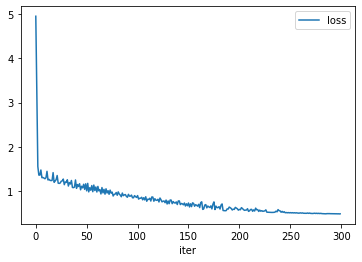

In [239]:
trace_df.plot(y='loss')

Text(0.5, 0.98, 'Learned parameter values per iteration\n (actual value is horisontal dashed line)')

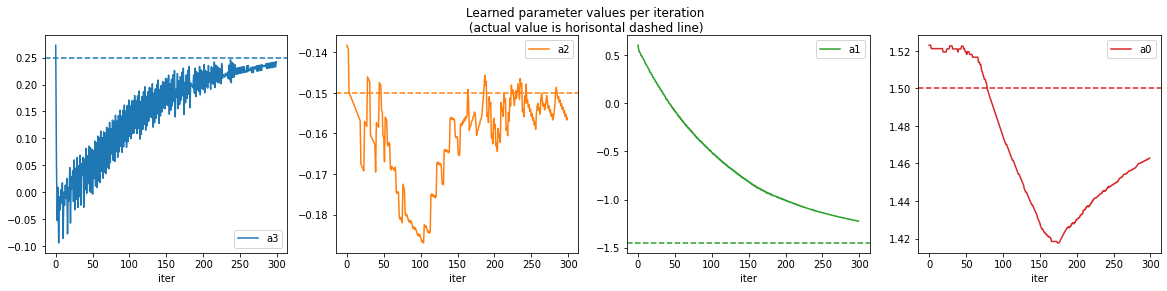

In [240]:
axs = trace_df.drop('loss',axis=1).plot(subplots=True, layout=(1, 4), figsize=(20, 4))
for i, ax in enumerate(axs[0]):
    ax.axhline(hiddent_actual_params[i], color=f"C{i}", linestyle='--')

plt.gcf().suptitle("Learned parameter values per iteration\n (actual value is horisontal dashed line)")

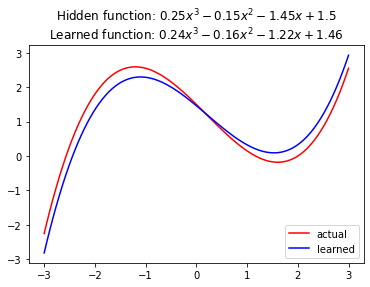

In [241]:
plot_func(hidden_function)
learned_params = m_params.detach().numpy() 
plot_func(make_pol3(*learned_params), 
          title=f"Hidden function: {hidden_func_title}\nLearned function: {format_cubic_polynomial(*learned_params)}"
          , color='blue')

plt.legend(['actual','learned','train data'])

In [242]:
if False:
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    plot_func(hidden_function,min_x=-10, max_x=10)
    learned_params = m_params.detach().numpy() 
    plot_func(make_pol3(*learned_params), 
              title=f"Hidden function: {hidden_func_title}\nLearned function: {format_cubic_polynomial(*learned_params)}", color='blue',
              min_x=-8, max_x=10)
    plt.scatter(train_x, train_y, alpha=0.7)

    plt.legend(['actual','learned','train data'])

# Fitting using gradient descent with relu functions

In [243]:
def relu(m, b, x):
    return torch.clip(m*x+b, 0)

In [244]:
@interact(
    m=(-5., 5.),
    b=(-5., 5.)
)
def choose_params_relu(m=1., b=-1.):
    f = partial(relu, m, b)
    plot_func(f, format_cubic_polynomial(0, 0, m, b), ylim=(-1, 7))

interactive(children=(FloatSlider(value=1.0, description='m', max=5.0, min=-5.0), FloatSlider(value=-1.0, desc…

In [245]:
def relu_n(params, x):
    n = len(params) // 2
    if len(params)%2 != 0:
        raise ValueError("Number of parameters should be even")
    res = 0
    for i in range(n):
        m = params[2*i]
        b = params[2*i+1]
        res += relu(m,b,x)
    return res

In [246]:
# manual plot

In [247]:
@interact(
    m1=(-5., 5.),
    b1=(-5., 5.),
    m2=(-5., 5.),
    b2=(-5., 5.),
    m3=(-5., 5.),
    b3=(-5., 5.)
)
def choose_params_relu(m1=1, b1=1, m2=-1, b2=-0.2, m3=3, b3=1):
    params = [m1, b1, m2, b2, m3, b3]
    f = partial(relu_n, params)
    loss = mae_loss(train_y, f(train_x))
    plot_func(f, f"Loss: {loss:.3f}")
    plt.scatter(train_x, train_y, alpha=0.7)

interactive(children=(FloatSlider(value=1.0, description='m1', max=5.0, min=-5.0), FloatSlider(value=1.0, desc…

In [248]:
# fit with gradient

In [249]:
def calc_model_loss_relu(model_params, train_x, train_y):
    y_pred = relu_n(model_params, train_x)
    return mae_loss(train_y, y_pred)

In [250]:
# init
N_RELU = 3
np.random.seed(42)
m_params = torch.tensor(np.random.normal(size=2*N_RELU), requires_grad=True)
m_params

tensor([ 0.4967, -0.1383,  0.6477,  1.5230, -0.2342, -0.2341],
       dtype=torch.float64, requires_grad=True)

In [251]:
learning_rate = 0.08
n_epocs = 1000
do_lr_decay = False
learning_trace = []
for i in range(n_epocs):
    current_loss = calc_model_loss_relu(m_params, train_x, train_y)
    current_loss.backward()
    with torch.no_grad():
        m_params -= m_params.grad * learning_rate
    m_params.grad = None
    if i%100==0:
        print(f"# {i}: loss: {current_loss:.10f}")
    if do_lr_decay and i%100 == 1:
        learning_rate *= 0.95 
    loss_val = current_loss.detach().numpy().tolist()
    learning_trace.append([i] + [loss_val] + m_params.detach().numpy().tolist())
#trace_df = pd.DataFrame.from_records(learning_trace, columns=['iter','loss','a3','a2','a1','a0']).set_index('iter')

# 0: loss: 1.9102405989
# 100: loss: 1.1358404352
# 200: loss: 1.1183913162
# 300: loss: 1.1020975127
# 400: loss: 1.0908644495
# 500: loss: 1.0826845564
# 600: loss: 1.0745046752
# 700: loss: 1.0666906456
# 800: loss: 1.0593973051
# 900: loss: 1.0539633095


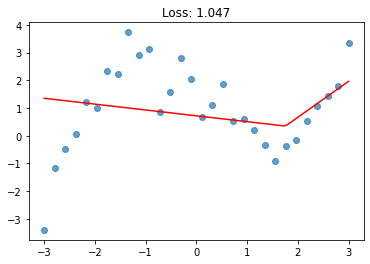

In [252]:
f = partial(relu_n, m_params.detach().numpy())
loss = mae_loss(train_y, f(train_x))
plot_func(f, f"Loss: {loss:.3f}")
plt.scatter(train_x, train_y, alpha=0.7)

# weighted relu (2-layered network)

In [253]:
def wrelu_n(relu_params, weights, x):
    if len(relu_params) != 2*len(weights):
        raise ValueError("Number of parameters doesn't match weights")
    res = 0
    for i in range(len(weights)):
        m = relu_params[2*i]
        b = relu_params[2*i+1]
        res += weights[i]*relu(m,b,x)
    return res

In [254]:
def calc_model_loss_wrelu(model_params, train_x, train_y):
    y_pred = wrelu_n(model_params['relu'], model_params['weights'], train_x)
    return mae_loss(train_y, y_pred)

In [278]:
# init
N_RELU = 3
np.random.seed(42)
m_params = {}
m_params['relu'] = torch.tensor(np.random.normal(size=2*N_RELU), requires_grad=True)
#m_params['weights'] = torch.tensor(np.ones(shape=N_RELU), requires_grad=True)
m_params['weights'] = torch.tensor(np.random.normal(size=N_RELU), requires_grad=True)

In [279]:
learning_rate = 0.08
n_epocs = 10_000
do_lr_decay = True
learning_trace = []
for i in range(n_epocs):
    current_loss = calc_model_loss_wrelu(m_params, train_x, train_y)
    current_loss.backward()
    with torch.no_grad():
        m_params['relu'] -= m_params['relu'].grad * learning_rate
        m_params['weights'] -= m_params['weights'].grad * learning_rate 
    m_params['relu'].grad = None
    m_params['weights'].grad = None
    if i%1000==0:
        print(f"# {i}: loss: {current_loss:.10f}")
    if do_lr_decay and i%1000 == 1:
        learning_rate *= 0.95 
    loss_val = current_loss.detach().numpy().tolist()
    learning_trace.append([i, loss_val])
trace_df = pd.DataFrame.from_records(learning_trace, columns=['iter','loss']).set_index('iter')

# 0: loss: 1.8551761437
# 1000: loss: 0.4294019416
# 2000: loss: 0.4394733570
# 3000: loss: 0.4354927866
# 4000: loss: 0.4339221697
# 5000: loss: 0.4317382595
# 6000: loss: 0.4444558981
# 7000: loss: 0.4317752998
# 8000: loss: 0.4380252707
# 9000: loss: 0.4286124608


In [280]:
m_params['relu']

tensor([ 1.3534, -2.6470, -1.0035,  1.3188, -2.1041, -2.8357],
       dtype=torch.float64, requires_grad=True)

In [281]:
m_params['weights']

tensor([ 1.8584,  1.1850, -2.0635], dtype=torch.float64, requires_grad=True)

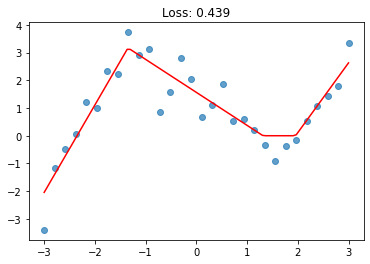

In [282]:
learned_f = partial(wrelu_n, m_params['relu'].detach().numpy(), m_params['weights'].detach().numpy())
loss = mae_loss(train_y, learned_f(train_x))
plot_func(learned_f, f"Loss: {loss:.3f}")
plt.scatter(train_x, train_y, alpha=0.7)

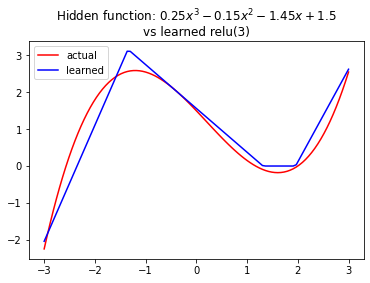

In [283]:
plot_func(hidden_function)
plot_func(learned_f, 
          title=f"Hidden function: {hidden_func_title}\nvs learned relu({N_RELU})", color='blue')
plt.legend(['actual','learned'])

* This exercise made me realise that we need a second layer (weights for outputs of each ReLu) to fit cubic function.
* Using plain sum is not enough as we couldn't 'turn the ReLu upside down' 
* My implementation of weights is hacky, yet it works.
* Experimenting with random seeds revealed another problem
  * for some random seed initialisation is "unlucky" and leads to a flat function, which lead to a flat gradient and no updates of coefficients
  * that's why different initialisations might be important as long as resetting the learning rate to unstuck from the local optimum
  * yet it's interesting that on small dimension the problem of overparametrisation is clear, but it doesn't hit LLMs where overparametrisation actually helps